## Imports

In [54]:
import os
import glob
import datetime

import jax
import numpyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

import sqlite3

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [55]:
df_raw = pd.read_stata('Data_Exp1234_clean.dta')

In [56]:
df_raw

,confidence,correct,true_shock,ab_nominal,rt,endowment,concentration,anxiety,totalmistakes,age,...,stake,stake_nominal,difficult,aligned,wishful,confusioncontrol,never_felt_deceived,bai,dpessimism,idtreatmentblock
0,0.60,1,1,20.00,4349.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,0.0,1.0,22.916664,NaN,5.0,1.190476,NaN,10.0
1,0.60,1,0,20.00,3796.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,1.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
2,0.65,0,0,20.00,2201.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,1.0,1.0,22.916664,NaN,5.0,1.190476,NaN,10.0
3,0.80,1,0,20.00,2945.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,0.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
4,0.70,0,0,20.00,3405.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,2.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97628,NaN,1,1,0.05,14534.5,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,0.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97629,NaN,1,0,0.05,15099.3,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,0.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97630,NaN,1,1,0.05,1715.6,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,2.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97631,NaN,0,1,0.05,2599.6,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,3.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0


## Definitions

In [57]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [58]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

In [59]:
def fit_hssm_participant(df, participant_column):
    all_summaries = []
    all_inferences = {}   # <- store InferData here

    for nsub, isub in enumerate(df[participant_column].unique()):
        print(f"___Participant {isub}, {nsub+1}/{df[participant_column].nunique()}___")

        df_sub = df[df[participant_column] == isub].drop(columns=[participant_column])

        print("Median RT =", np.median(df_sub['rt']))
        print("N trials =", len(df_sub))

        model = hssm.HSSM(
            model="ddm",
            data=df_sub,
        )

        infer_data_sub = model.sample(
            cores=3,
            chains=3,
            draws=300,
            tune=1000,
            idata_kwargs=dict(log_likelihood=True),
            progressbar=True,
            target_accept=0.99,
        )

        all_inferences[isub] = infer_data_sub

        summary_df = (
            az.summary(infer_data_sub)
              .reset_index()
              .rename(columns={'index': 'param'})
        )
        summary_df['participant_id'] = isub
        all_summaries.append(summary_df)

    all_summaries_df = pd.concat(all_summaries, ignore_index=True)
    return all_summaries_df, all_inferences

In [60]:
def write_to_sql(df, db_name, table_name):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists="append", index=False)
    conn.close()

### Data Cleanup

In [61]:
columns_to_keep = [
    'id',              # Participant ID (for hierarchical fitting)
    'trial',           # Trial Number (for indexing/sequencing)
    'experiment',      # Filter column (must be 4)
    'rt',              # Response Time (The dependent variable distribution)
    'correct',         # Accuracy (The outcome predicted by DDM)
    'ab_nominal',      # Accuracy Bonus (Incentive condition)
    'stake_nominal',   # Loss Size (Incentive condition)
    'difficult',        # Task Difficulty (Signal quality condition)
    'endowment',      # Initial amount (Incentive con
]

In [62]:
data = df_raw.copy()
data = data[columns_to_keep]

data.rename(columns={
    'id':'participant'
}, inplace=True)

## Stim evidence: low vs high (0/1)
#data['endowment_2'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['endowment']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [63]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['correct'].isna())]

In [64]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]

In [65]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

N trials excluded = 8259 / 97633
Mean RT = 2488 ms, median RT = 1525 ms, max RT = 34963 ms


In [66]:
data

,participant,trial,experiment,rt,correct,ab_nominal,stake_nominal,difficult,endowment
1,1.0,2.0,1.0,3796.0,1,20.00,NaN,1.0,NaN
2,1.0,3.0,1.0,2201.0,0,20.00,NaN,1.0,NaN
3,1.0,4.0,1.0,2945.0,1,20.00,NaN,0.0,NaN
4,1.0,5.0,1.0,3405.0,0,20.00,NaN,2.0,NaN
5,1.0,6.0,1.0,1844.0,0,20.00,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...
97628,1114.0,71.0,4.0,14534.5,1,0.05,0.0,0.0,0.0
97629,1114.0,72.0,4.0,15099.3,1,0.05,0.0,0.0,0.0
97630,1114.0,73.0,4.0,1715.6,1,0.05,0.0,2.0,0.0
97631,1114.0,74.0,4.0,2599.6,0,0.05,0.0,3.0,0.0


## Participant Cleanup

In [67]:
data = data[data['experiment']==4]

In [68]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

N participants kept (accuracy) = 397 / 407
N participants kept (RT) = 343 / 397
N participants kept after excluding participants with too few trials = 343 / 343


In [69]:
data = data[data['experiment']==4]

In [70]:
len(data.participant.unique())

343

## HSSM DataFrame

In [71]:
data

,participant,trial,experiment,rt,correct,ab_nominal,stake_nominal,difficult,endowment
63495,708.0,1.0,4.0,1454.6,0,0.05,0.0,3.0,0.0
63496,708.0,2.0,4.0,2016.7,0,0.05,0.0,0.0,0.0
63497,708.0,3.0,4.0,959.7,1,0.05,0.0,0.0,0.0
63498,708.0,4.0,4.0,910.2,1,0.05,0.0,3.0,0.0
63499,708.0,5.0,4.0,1021.8,0,0.05,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
97552,1113.0,79.0,4.0,1329.4,1,10.00,1.0,0.0,5.0
97553,1113.0,80.0,4.0,1506.9,1,10.00,1.0,1.0,5.0
97554,1113.0,81.0,4.0,1345.2,1,10.00,1.0,0.0,5.0
97555,1113.0,82.0,4.0,2321.0,0,10.00,1.0,3.0,5.0


In [72]:
df_hssm = pd.DataFrame({
    'response': data['correct'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [73]:
df_hssm

,response,rt,participant_id
63495,0,1.4546,708
63496,0,2.0167,708
63497,1,0.9597,708
63498,1,0.9102,708
63499,0,1.0218,708
...,...,...,...
97552,1,1.3294,1113
97553,1,1.5069,1113
97554,1,1.3452,1113
97555,0,2.3210,1113


# Test dataset

In [74]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/10),
    replace = False
)

In [75]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [76]:
df_hssm.participant_id.nunique(), df_test.participant_id.nunique()

(343, 34)

In [77]:
df_test

,response,rt,participant_id
64511,1,0.9147,720
64512,1,1.4610,720
64513,1,1.0383,720
64515,1,1.3669,720
64516,1,1.1600,720
...,...,...,...
96758,0,1.9658,1104
96759,1,4.0500,1104
96761,1,2.9539,1104
96762,1,2.8644,1104


# Partial dataset for fitting

In [78]:
part_df = df_test.copy()

In [79]:
fitted_participantd_ids = pd.read_sql_query("SELECT DISTINCT participant_id FROM summaries", sqlite3.connect('hssm_fits.db'))

In [80]:
len(fitted_participantd_ids)

251

In [81]:
df_test

,response,rt,participant_id
64511,1,0.9147,720
64512,1,1.4610,720
64513,1,1.0383,720
64515,1,1.3669,720
64516,1,1.1600,720
...,...,...,...
96758,0,1.9658,1104
96759,1,4.0500,1104
96761,1,2.9539,1104
96762,1,2.8644,1104


In [82]:
part_df = df_test[~df_test['participant_id'].isin(fitted_participantd_ids.participant_id.values)]

In [83]:
part_df.participant_id.nunique()

9

## Fit model

In [84]:
df_fit_output, az_data = fit_hssm_participant(part_df, 'participant_id')

___Participant 750, 1/9___
Median RT = 1.4865
N trials = 76


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 773, 2/9___
Median RT = 3.8673
N trials = 69


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 778, 3/9___
Median RT = 1.8901
N trials = 61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 809, 4/9___
Median RT = 2.3109
N trials = 83


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 859, 5/9___
Median RT = 1.8325
N trials = 84


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 991, 6/9___
Median RT = 1.49925
N trials = 58


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 1047, 7/9___
Median RT = 2.3045502
N trials = 74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 1048, 8/9___
Median RT = 4.8446
N trials = 95


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 1076, 9/9___
Median RT = 1.5494
N trials = 93


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, t, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [85]:
df_fit_output

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,0.146,0.194,-0.243,0.502,0.010,0.007,343.0,407.0,1.01,750
1,a,0.927,0.059,0.819,1.044,0.004,0.003,230.0,337.0,1.02,750
2,t,0.861,0.046,0.758,0.927,0.006,0.004,74.0,124.0,1.04,750
3,z,0.644,0.046,0.556,0.728,0.003,0.002,247.0,322.0,1.00,750
4,v,0.470,0.123,0.254,0.700,0.008,0.006,255.0,258.0,1.00,773
5,a,2.222,0.219,1.847,2.607,0.012,0.009,356.0,352.0,1.02,773
6,t,0.964,0.213,0.565,1.329,0.015,0.011,225.0,218.0,1.01,773
7,z,0.561,0.072,0.432,0.694,0.005,0.003,241.0,339.0,1.02,773
8,v,0.412,0.130,0.151,0.637,0.006,0.005,442.0,556.0,1.01,778
9,a,1.310,0.099,1.107,1.471,0.006,0.004,272.0,467.0,1.01,778


# store data

In [86]:
write_to_sql(df_fit_output, 'hssm_fits.db', 'summaries')

# az plot

In [87]:
#az.plot_posterior(az_data[1080])

# Drift rate plots

In [88]:
df_v = df_fit_output[df_fit_output['param']=='v']

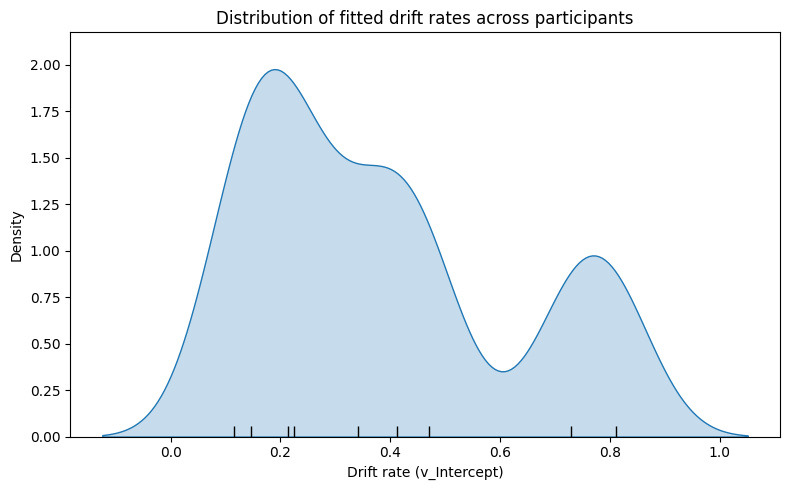

In [89]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Drift rate (v_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()

# Read SQL

In [90]:
query = "SELECT * FROM summaries"
conn = sqlite3.connect('hssm_fits.db')
df_all = pd.read_sql_query(query, conn)
conn.close()

In [91]:
df_all

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,0.513,0.174,0.213,0.866,0.010,0.007,312.0,261.0,1.01,935
1,t,0.637,0.060,0.516,0.728,0.004,0.003,232.0,402.0,1.01,935
2,a,1.004,0.078,0.860,1.140,0.005,0.003,294.0,491.0,1.01,935
3,z,0.506,0.048,0.408,0.588,0.002,0.002,498.0,339.0,1.00,935
4,v,0.634,0.150,0.347,0.903,0.008,0.005,396.0,539.0,1.01,1062
...,...,...,...,...,...,...,...,...,...,...,...
1227,z,0.618,0.044,0.542,0.702,0.003,0.002,204.0,499.0,1.02,1048
1228,v,0.341,0.135,0.079,0.579,0.007,0.005,345.0,496.0,1.01,1076
1229,a,1.110,0.062,1.004,1.226,0.003,0.002,561.0,586.0,1.00,1076
1230,t,0.593,0.040,0.516,0.663,0.002,0.001,500.0,377.0,1.00,1076


In [92]:
df_all[df_all['participant_id']==907]

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
876,v,0.164,0.121,-0.045,0.399,0.006,0.004,387.0,585.0,1.01,907
877,t,0.748,0.066,0.628,0.852,0.004,0.003,304.0,384.0,1.01,907
878,a,1.483,0.105,1.292,1.675,0.005,0.004,374.0,383.0,1.02,907
879,z,0.644,0.051,0.553,0.738,0.003,0.002,324.0,429.0,1.01,907
1012,v,0.164,0.121,-0.045,0.399,0.006,0.004,387.0,585.0,1.01,907
1013,t,0.748,0.066,0.628,0.852,0.004,0.003,304.0,384.0,1.01,907
1014,a,1.483,0.105,1.292,1.675,0.005,0.004,374.0,383.0,1.02,907
1015,z,0.644,0.051,0.553,0.738,0.003,0.002,324.0,429.0,1.01,907


In [94]:
participant_counts = df_all['participant_id'].value_counts()
participants_more_than_4 = participant_counts[participant_counts > 4].index.tolist()
print(participants_more_than_4)

[802, 966, 911, 917, 918, 928, 941, 963, 971, 1103, 996, 997, 1004, 1019, 1029, 1053, 907, 902, 895, 891, 882, 879, 869, 865, 822, 804, 795, 775, 765, 762, 755, 720, 709, 1105, 1055, 781, 892, 712, 718, 722, 792, 849, 888, 889, 964, 994, 1095, 1098]


In [95]:
1164/4

291.0

In [ ]:
df_all.participant_id.nunique()

260

# split dfs

In [97]:
df_v_all = df_all[df_all['param']=='v'] #drift
df_th_all = df_all[df_all['param']=='a'] #th
df_t_all = df_all[df_all['param']=='t'] #ndt
df_z_all = df_all[df_all['param']=='z'] #bias

In [98]:
df_v_all.describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.453263,0.152325,0.172756,0.737221,0.009208,0.006578,346.279221,421.318182,1.010455,906.542208
std,0.223690,0.038042,0.203752,0.265567,0.005121,0.003718,110.953815,117.559062,0.019248,116.993561
min,-0.037000,0.049000,-0.355000,0.211000,0.003000,0.002000,16.000000,35.000000,1.000000,708.000000
25%,0.309750,0.126000,0.054250,0.564250,0.006000,0.005000,286.250000,349.500000,1.000000,802.750000
50%,0.430000,0.150000,0.173500,0.723000,0.008000,0.006000,368.500000,433.000000,1.010000,898.500000
75%,0.596000,0.174000,0.288500,0.894000,0.010000,0.007000,418.250000,505.000000,1.010000,1004.250000
max,1.346000,0.309000,0.848000,1.848000,0.039000,0.028000,578.000000,672.000000,1.150000,1113.000000


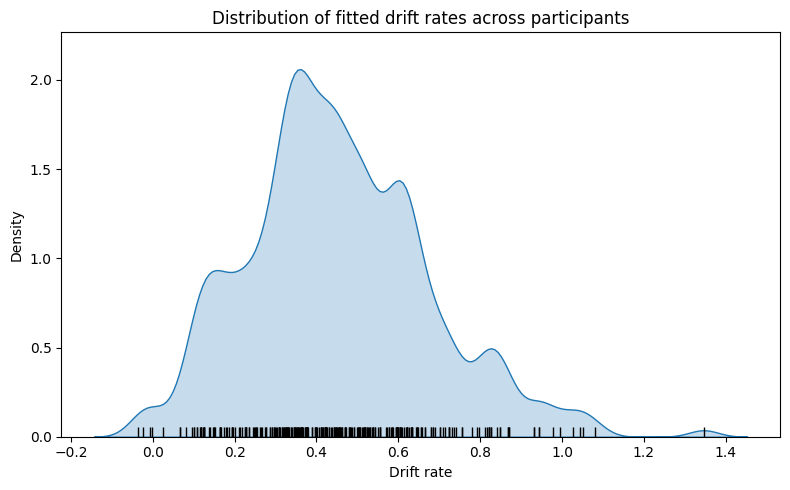

In [99]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_v_all['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v_all['mean'], color='k')
plt.xlabel("Drift rate")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()

# th

In [100]:
df_th_all.describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,1.309214,0.102445,1.134601,1.497649,0.006955,0.004961,352.948052,405.827922,1.013831,906.542208
std,0.410977,0.087268,0.319380,0.540178,0.009401,0.006812,127.947531,129.017711,0.038619,116.993561
min,0.517000,0.023000,0.477000,0.561000,0.002000,0.001000,6.000000,28.000000,1.000000,708.000000
25%,1.027500,0.064000,0.908750,1.153250,0.003000,0.002000,263.000000,339.750000,1.000000,802.750000
50%,1.250500,0.084000,1.096500,1.409500,0.004000,0.003000,369.000000,426.500000,1.010000,898.500000
75%,1.521500,0.105000,1.332000,1.724000,0.006000,0.004000,447.000000,491.250000,1.010000,1004.250000
max,3.600000,0.713000,2.811000,4.645000,0.077000,0.057000,635.000000,660.000000,1.420000,1113.000000


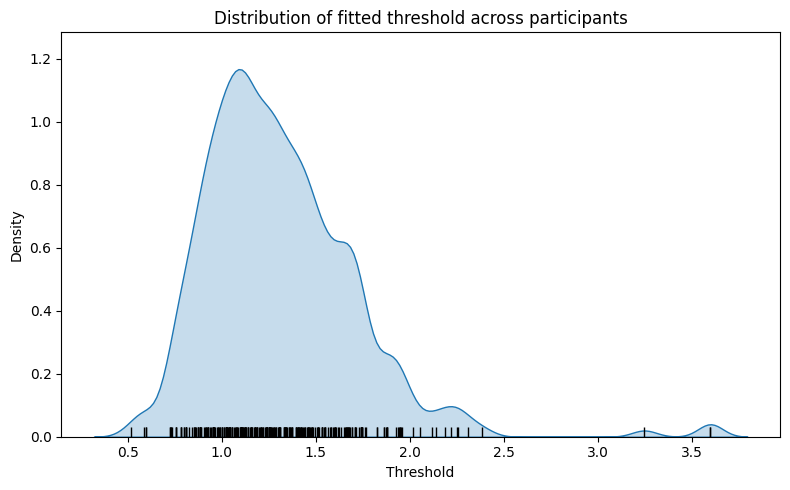

In [101]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_th_all['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_th_all['mean'], color='k')
plt.xlabel("Threshold")
plt.ylabel("Density")
plt.title("Distribution of fitted threshold across participants")
plt.tight_layout()
plt.show()

# ndt

In [102]:
df_t_all.describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.776308,0.078656,0.633065,0.911360,0.007081,0.005146,285.659091,317.646104,1.018864,906.542208
std,0.267311,0.054719,0.263995,0.305586,0.017287,0.013515,116.759214,127.686536,0.053888,116.993561
min,0.168000,0.007000,0.000000,0.297000,0.001000,0.000000,5.000000,18.000000,1.000000,708.000000
25%,0.621000,0.040000,0.497000,0.712750,0.002000,0.002000,205.000000,236.500000,1.000000,802.750000
50%,0.716000,0.066000,0.604000,0.836500,0.004000,0.003000,298.000000,325.000000,1.010000,898.500000
75%,0.890250,0.100000,0.747000,1.035000,0.007000,0.005000,371.000000,405.250000,1.020000,1004.250000
max,2.734000,0.480000,2.179000,3.490000,0.264000,0.209000,603.000000,655.000000,1.680000,1113.000000


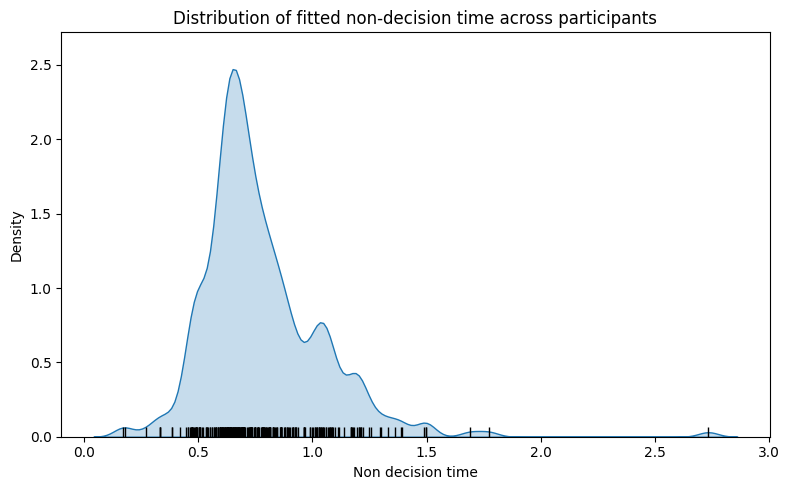

In [103]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_t_all['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_t_all['mean'], color='k')
plt.xlabel("Non decision time")
plt.ylabel("Density")
plt.title("Distribution of fitted non-decision time across participants")
plt.tight_layout()
plt.show()

# initial bias

In [104]:
df_z_all.describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.521448,0.051776,0.425244,0.616828,0.003448,0.002539,321.889610,396.701299,1.014318,906.542208
std,0.059798,0.011293,0.061293,0.064582,0.002741,0.001939,110.472221,124.719784,0.037476,116.993561
min,0.332000,0.037000,0.241000,0.415000,0.002000,0.001000,8.000000,28.000000,1.000000,708.000000
25%,0.482250,0.045750,0.385750,0.576000,0.002000,0.002000,263.000000,314.500000,1.000000,802.750000
50%,0.519000,0.049000,0.425000,0.615500,0.003000,0.002000,330.500000,409.500000,1.010000,898.500000
75%,0.558000,0.054000,0.464000,0.652000,0.003000,0.002000,398.000000,481.000000,1.010000,1004.250000
max,0.727000,0.119000,0.592000,0.879000,0.025000,0.018000,571.000000,697.000000,1.340000,1113.000000


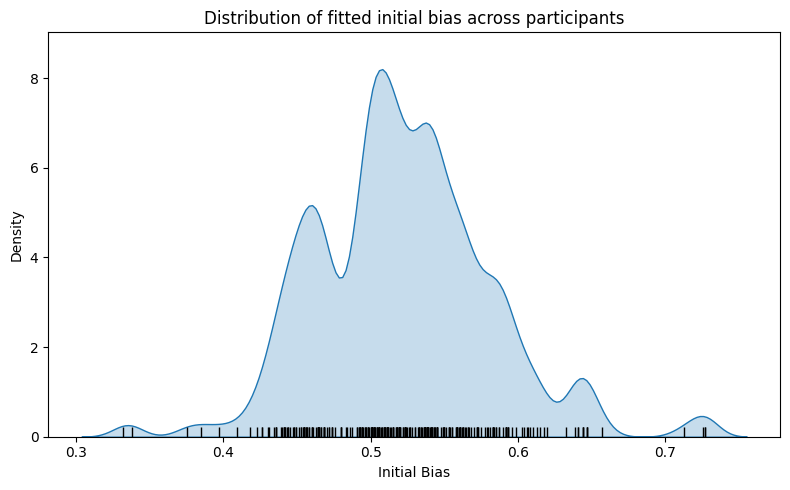

In [105]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_z_all['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_z_all['mean'], color='k')
plt.xlabel("Initial Bias")
plt.ylabel("Density")
plt.title("Distribution of fitted initial bias across participants")
plt.tight_layout()
plt.show()